# BioPlux Testdata Analysis

## Imports and Presets

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

### Define Project-Root Directory

In [3]:
PROJECT_ROOT = 'bio-feedback'

### Navigate to Project-Root Directory

In [4]:
currend_wd = os.getcwd()
project_root_abs = os.path.join(currend_wd[:currend_wd.find(PROJECT_ROOT)], PROJECT_ROOT)
os.chdir(project_root_abs)

### Import Project-Specific Libraries

In [5]:
from biofb.io import SessionDatabase as SessionDB

## Load Session Database

In [6]:
db = SessionDB.load(filename='data/session/db-2021-01-19-bioplux.yml')

[print(s) for s in db.samples];

<Sample: Subject 882947 at 2021-01-19 15:03:08>
<Sample: Subject 882947 at 2021-01-19 16:25:04>
<Sample: Subject 165278 at 2021-01-19 16:57:20>
<Sample: Subject 165278 at 2021-01-19 17:00:33>
<Sample: Subject 925022 at 2021-01-19 17:33:17>
<Sample: Subject 925022 at 2021-01-19 17:35:02>


In [7]:
data_slice = slice(0,-1,1)

In [8]:
@interact
def view_bioplux(
    sample=[i for i in range(len(db.samples))],
    label_by=['name', 'label'],
    show_sftf=False,
    cmap='magma',
    update=False,
):

    try:
        s = db.samples[int(sample)]
        s_time = s.time[0]
        s_data = s.data[0]

        f, axes = plt.subplots(len(s.setup.devices[0].channels), 1, figsize=(15,20), sharex=True)

        if show_sftf:

            for ax, channel in zip(axes, s.setup.devices[0].channels):
                sr = channel.sampling_rate
                data = channel.data
                Pxx, freqs, bins, im = ax.specgram(data[data_slice], NFFT=sr, Fs=sr, noverlap=sr//2, scale='dB', cmap=cmap)
                ax.set_ylabel(getattr(channel, label_by))
                ax.set_ylim([0,60])
            axes[-1].set_xlabel('Time')
            
        else:
            s.setup.devices[0].plot(axes=axes, label_by=label_by)
            axes[-1].set_xlim([s_time[data_slice, 0][0], s_time[data_slice, 0][-1]])          
        plt.tight_layout

        print(s)
        print()
        [print(c) for c in s.comments]
    except Exception as ex:
        print('something went wrong:', ex)
        raise ex


interactive(children=(Dropdown(description='sample', options=(0, 1, 2, 3, 4, 5), value=0), Dropdown(descriptio…

## Example Sample 0

In [9]:
s = db.samples[0]

print(s)

<Sample: Subject 882947 at 2021-01-19 15:03:08>


### Subjects are assigned to a sample

In [10]:
print(s.subject)
print(f'identity: {s.subject.identity}')

<Subject: 882947>
identity: 882947


### An experimental setting is defined

In [11]:
print(s.setting)
print(s.setting.description)

<Setting: Setup test>



### A setup has a technical setup (defined list of devices)

In [12]:
print(s.setup)
print(s.setup.description)

<Setup: Bioplux>
OpenSingals (r)evolution data acquisition.


### For the setup a single `biolux` device has been defined

In [13]:
for d in s.setup.devices:
    print(d)

<Bioplux: bioplux>


### Devices can be accessed via their device name

In [14]:
bioplux = s.setup['bioplux']
print(bioplux)
print(bioplux is s.setup.devices[0])

<Bioplux: bioplux>
True


### Devices have channels

In [15]:
for c in bioplux.channels:
    print(c)

<DI-Channel: DI>
<EOG-Channel: EOG>
<ECG-Channel: ECG>
<PZT-Channel: RESPIRATION>
<EEG-Channel: EEG>
<EDA-Channel: EDA>
<FSW-Channel: CUSTOM/0.5/1.0/V>


### Channels can also be accessed via their channel names

In [16]:
ecg = bioplux['ECG']

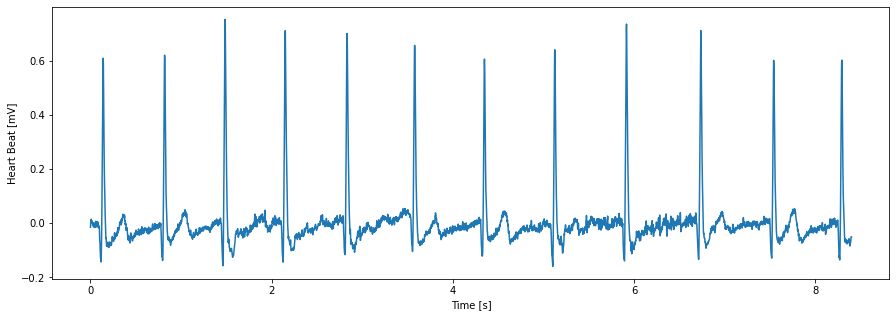

In [17]:
plt.figure(figsize=(15,5))
plt.plot(ecg.time, ecg.data)
plt.ylabel('Heart Beat [mV]')
plt.xlabel('Time [s]')
plt.show()

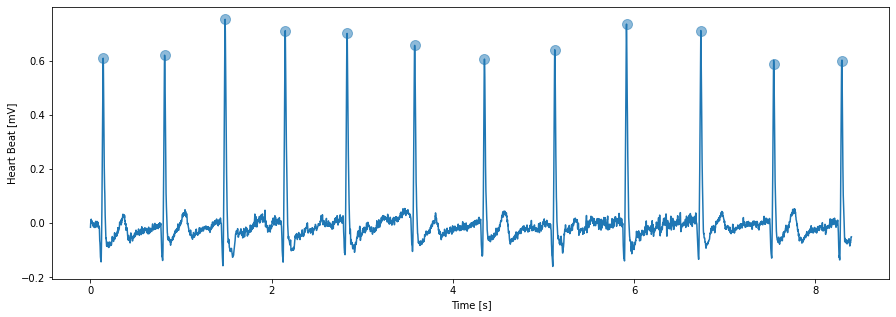

In [18]:
r_peaks = ecg.get_R_peaks()
plt.figure(figsize=(15,5))
plt.plot(ecg.time, ecg.data)
plt.scatter(ecg.time[r_peaks], ecg.data[r_peaks], s=100, alpha=0.5)
plt.ylabel('Heart Beat [mV]')
plt.xlabel('Time [s]')
plt.show()

Text(0, 0.5, 'Breathing Frequency')

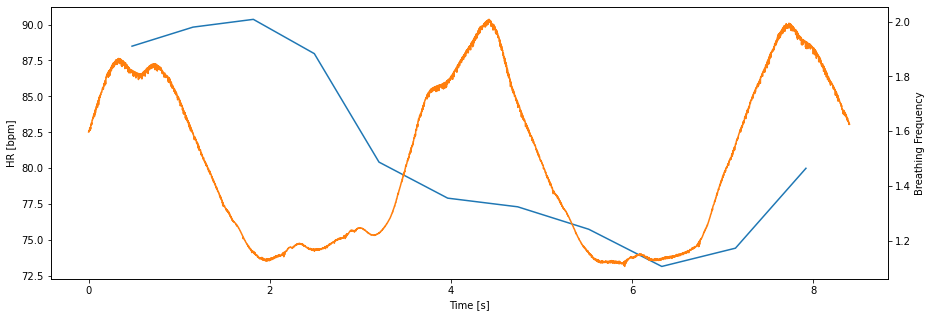

In [19]:
plt.figure(figsize=(15,5))
hr_time, hr = ecg.get_heart_rate(R_peaks=r_peaks)

ax = plt.gca()
ax.plot(hr_time, hr, label='heart rate')
ax.set_xlabel('Time [s]')
ax.set_ylabel('HR [bpm]')

ax1 = plt.gca().twinx()
ax1.plot(c.time, s.setup.devices[0]['RESPIRATION'].data, color='tab:orange', label='respiration')
ax1.set_ylabel('Breathing Frequency')